In [43]:
%precision 3

import numpy as np
import pandas as pd
from pathlib import Path
from scipy.stats import gaussian_kde
from sklearn import preprocessing, decomposition
from IPython import display
from matplotlib import pyplot as plt
from matplotlib import ticker, collections, colors
plt.style.use("minimal")

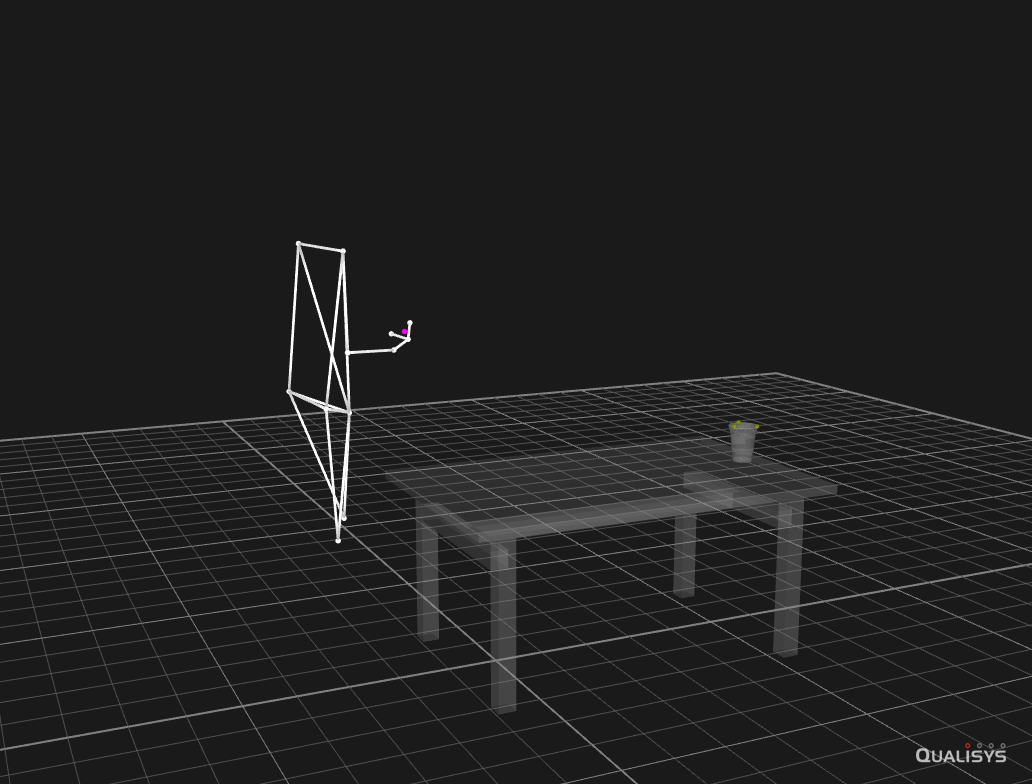

In [44]:
display.Image("../Export/full.gif")

In [45]:
METADATA_ROWS_N     = 9 # number of lines to skip in logfile
SPATIAL_SCALE       = 1000 # spatial measurements were recorded in millimeters
SAMPLE_RATE         =  300 # Hz (samples/second)
DISPATCH_MARGIN     = 0.4 # number of seconds before dispatch to consider in analysis
DATA_PATH           = "../data" # path to logfile directories

In [46]:
class Recording:
    def __init__(self, datafile_path):
        self.datafile_path = datafile_path

        self.events = pd.read_csv(
            datafile_path, 
            sep = "\t", 
            header = None, 
            names = ("Type", "EventType", "Frame", "Time"), 
            skiprows = METADATA_ROWS_N, 
            on_bad_lines = "skip"
        ).drop(columns = ["Type"])

        marker_names = pd.read_csv(
            datafile_path, 
            sep = "\t", 
            header = None, 
            skiprows = METADATA_ROWS_N + len(self.events), 
            nrows = 1
        ).loc[0, 1:].values

        self.available_markers = list(sorted(marker_names))

        dataset = pd.read_csv(
            datafile_path, 
            sep = "\t", 
            header = METADATA_ROWS_N + len(self.events) + 2, 
            usecols = lambda name: "Unnamed" not in name
        )

        dataset = dataset.set_index(["Frame", "Time"])
        dataset.columns = dataset.columns.str.split(" ", expand = True)
        dataset = dataset.stack(0, dropna = False)
        dataset.index = dataset.index.rename(["Frame", "Time", "Marker"])
        dataset = dataset.reset_index()

        dataset["TrialTag"] = dataset["Frame"].isin(self.events[self.events["EventType"] == "Trial"]["Frame"])
        dataset["Trial"] = (dataset["TrialTag"].astype(int).diff() > 0).cumsum()
        dataset = dataset[dataset["Trial"] > 0]

        dataset["OutcomeTag"] = dataset["Frame"].isin(self.events[self.events["EventType"] == "Hit"]["Frame"])

        trials = []
        for trial, subset in dataset.groupby("Trial"):
            marker_collection = []
            subset["Frame"] -= subset["Frame"].min()
            subset["Time"] -= subset["Time"].min()
            for marker in self.available_markers:
                pos_data = subset[subset["Marker"] == marker][["Frame", "Time"] + list("XYZ")].set_index(["Frame", "Time"])
                pos_data = pos_data.interpolate(limit_direction = "both")
                pos_data = (pos_data / SPATIAL_SCALE) * 100 # rescale from mm/s to cm
                marker_collection.append(pos_data.reset_index())
            trial_data = pd.Series(marker_collection, name = "Marker", index = self.available_markers)
            trial_data.success = subset["OutcomeTag"].any()
            trials.append(trial_data)

        self.data = pd.Series(data = trials, index = np.arange(1, len(trials) + 1), name = "Trial")

        self.enhance()

    def calculate_speed(self, subset):
        delta_pos = (subset[["X", "Y", "Z"]].shift(1).values - subset[["X", "Y", "Z"]].values) * SAMPLE_RATE
        speed = np.sqrt(np.sum(delta_pos ** 2, axis = 1))
        speed = pd.Series(speed).rolling(int(SAMPLE_RATE / 10)).mean() # smoothen with rolling average
        speed /= 100 # rescale from cm/s to m/s
        return speed

    def calculate_acceleration(self, subset):
        return (subset["Speed"].diff() / SAMPLE_RATE).rolling(int(SAMPLE_RATE / 10)).mean() # smoothen with rolling average

    def sync_and_trim(self, subset, reference_timepoint, pre = None, post = None):
        if pre and post:
            subset = subset[(subset["Time"] > reference_timepoint - pre) & (subset["Time"] < reference_timepoint + post)].copy()
        subset["Time"] -= subset["Time"].min()
        subset.index -= subset.index.min()
        return subset

    def recenter_to_cup(self, subset, cup_centroid):
        subset[["X", "Y", "Z"]] = subset[["X", "Y", "Z"]].subtract(cup_centroid)
        return subset

    def enhance(self):
        for trial in self.data.index:
            cup_centroid = pd.DataFrame([self.data[trial][cup_marker][["X", "Y", "Z"]].median() for cup_marker in ["CupLeft", "CupRight", "CupFront"]]).mean()

            # adding derived measures
            for marker in self.data[trial].index:
                self.recenter_to_cup(self.data[trial][marker], cup_centroid)
                self.data[trial][marker]["Speed"] = self.calculate_speed(self.data[trial][marker])
                self.data[trial][marker]["Acceleration"] = self.calculate_acceleration(self.data[trial][marker])

            # trimming to throw by using max ball speed (terminal velocity)
            reference_timepoint = self.data[trial]["Ball"].iloc[self.data[trial]["Ball"]["Speed"].replace(np.nan, 0).idxmax()]["Time"]
            for marker in self.data[trial].index:
                self.data[trial][marker] = self.sync_and_trim(
                    self.data[trial][marker], 
                    reference_timepoint, 
                    pre = 1, 
                    post = DISPATCH_MARGIN
                )

            # trimming and "centering" around throw movement instead of terminal velocity
            reference_timepoint = self.data[trial]["Ball"].iloc[self.data[trial]["Ball"]["Acceleration"].replace(np.nan, 0).idxmax()]["Time"]
            for marker in self.data[trial].index:
                self.data[trial][marker] = self.sync_and_trim(
                    self.data[trial][marker], 
                    reference_timepoint, 
                    pre = DISPATCH_MARGIN, 
                    post = 0.6
                )

    def __repr__(self):
        return f"[Recording {self.id}]" + "\n" + f"Trial{'s' if len(self.data) > 1 else ''} {self.data.index[0]}{'-' + str(self.data.index[-1]) if len(self.data.index) > 1 else ''}" + "\n" + f"{len(self.available_markers)} markers ({', '.join(self.available_markers)})"

class Session:
    def __init__(self, session_id):
        self.session_id = session_id

        recordings = []
        for recording_path in Path(DATA_PATH).joinpath(f"Session{self.session_id}").iterdir():
            if recording_path.suffix == ".tsv":
                recordings.append(dict(
                    Player = int(recording_path.name[6]),
                    Condition = recording_path.stem.split("_")[1],
                    Recording = Recording(datafile_path=recording_path).data
                ))
        self.data = pd.DataFrame(recordings)

    def __repr__(self):
        return f"[Session {self.session_id}]" + "\n" + data[["Player", "Condition"]].to_string(index = False)

session = Session(session_id = 1)
print(session)

data = session.data

[Session 1]
 Player Condition
      1  Darkness
      1  Daylight


In [47]:
def annotate_metadata(marker, axis = None):
    plt.figtext(0.9, 0.9, f"{marker}" + f"{' ' + axis if axis else ''}", ha = "center")
    # plt.figtext(1, 0.04, f"{len(data)} trials", ha = "center", alpha = 0.5)

def mark_dispatch():
    plt.axvline(DISPATCH_MARGIN, color = "black", linestyle = "--", linewidth = 1, alpha = 0.05, zorder = -1)

def decorate_xaxis_ticks():
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    plt.gca().xaxis.set_major_formatter(lambda val, idx: int(val * 1000))
    plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.05))

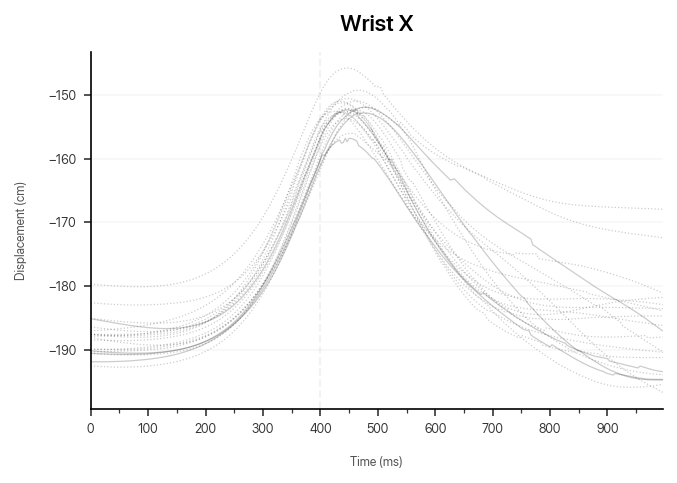

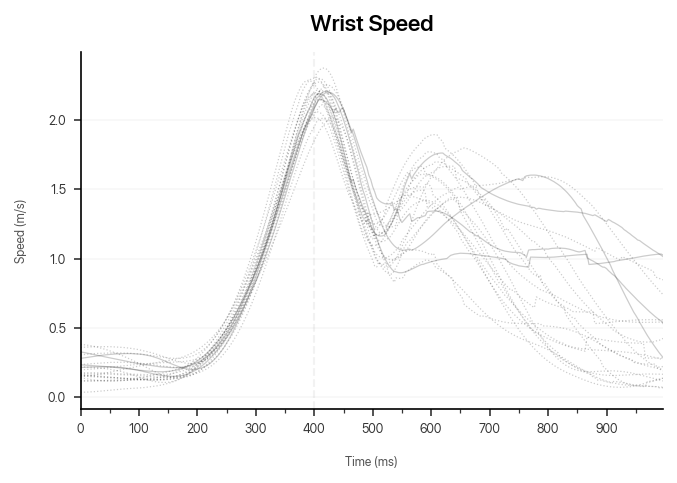

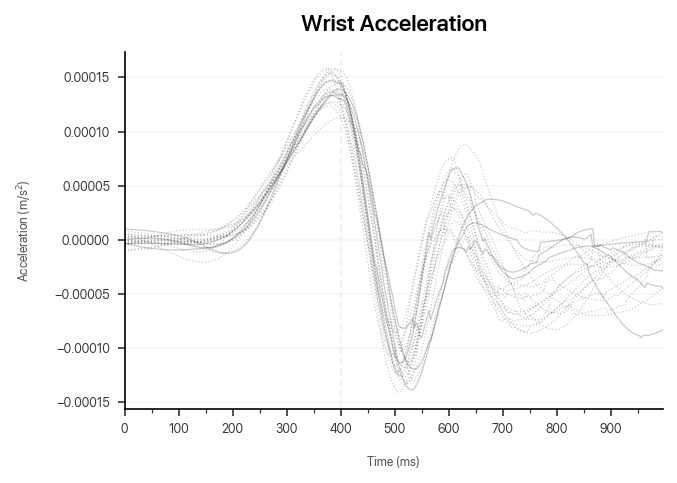

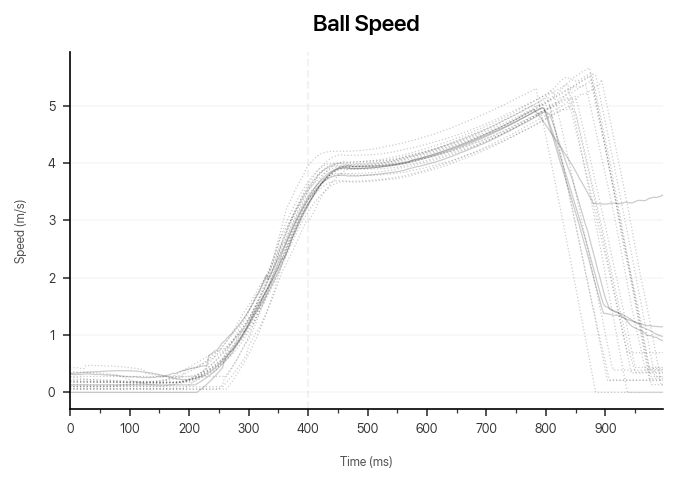

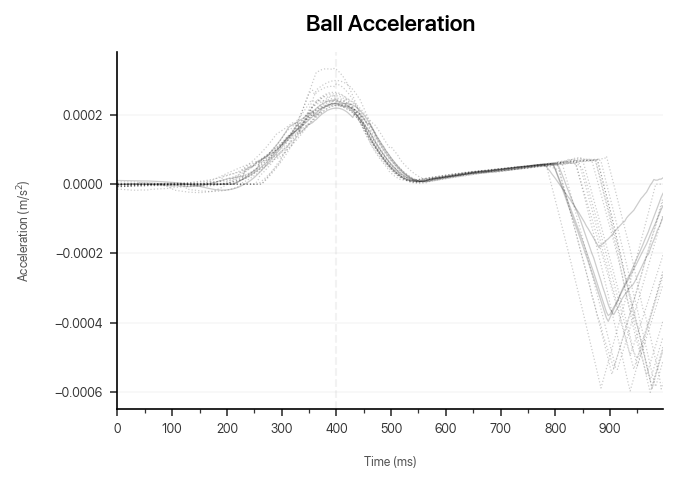

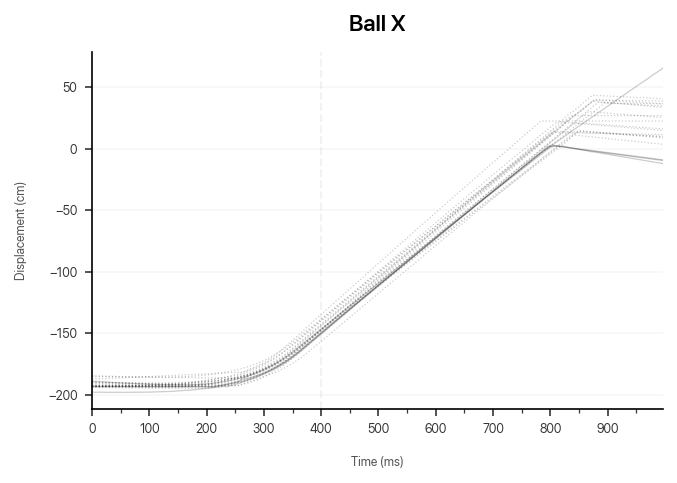

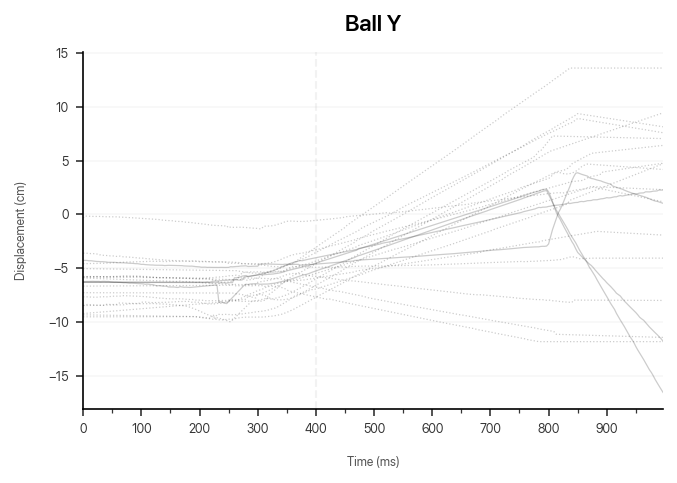

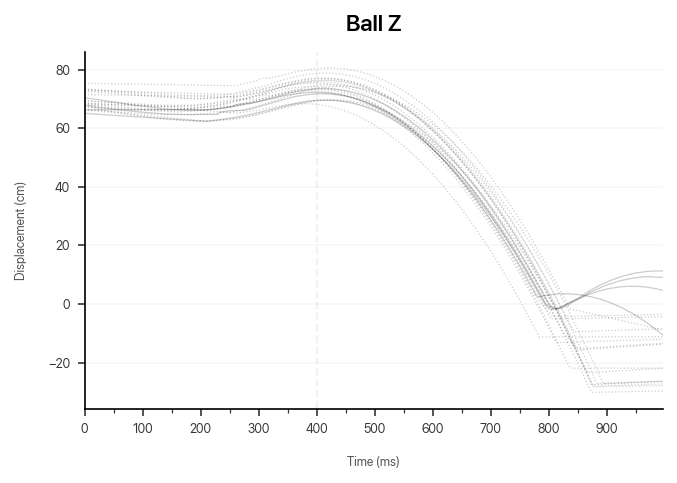

In [48]:
def plot_trajectory(marker, dimension):
    plt.figure()
    mark_dispatch()
    for recording in data["Recording"]:
        for trial, subset in recording.items():
            plt.plot(
                subset[marker]["Time"],
                subset[marker][dimension], 
                color = "black",
                linewidth = 0.6, 
                linestyle = "-" if subset.success else ":",
                alpha = 0.2
            )

    plt.title(f"{marker} {dimension}")
    plt.xlabel("Time (ms)")
    if dimension == "Speed":
        plt.ylabel(f"{dimension} (m/s)")
    elif dimension == "Acceleration":
        plt.ylabel(f"{dimension} (m/s$^2$)")
    else:
        plt.ylabel("Displacement (cm)")

    decorate_xaxis_ticks()
    plt.margins(x = 0, y = 0.05)
    plt.tight_layout()

plot_trajectory(marker = "Wrist", dimension = "X")
plot_trajectory(marker = "Wrist", dimension = "Speed")
plot_trajectory(marker = "Wrist", dimension = "Acceleration")
plot_trajectory(marker = "Ball", dimension = "Speed")
plot_trajectory(marker = "Ball", dimension = "Acceleration")
plot_trajectory(marker = "Ball", dimension = "X")
plot_trajectory(marker = "Ball", dimension = "Y")
plot_trajectory(marker = "Ball", dimension = "Z")

In [49]:
def summary():
    result = []
    for index, (player, condition, recording) in data.iterrows():
        for trial, subset in recording.items():

            after_passing_cup = subset["Ball"]["X"] > 0

            result.append({
                "Player": player, 
                "Condition": condition, 
                "Trial": trial, 
                # "Outcome": "✔" if subset.success else "✗",
                "Outcome": "Hit" if subset.success else "Miss",
                "Ball Max Speed (m/s)": subset["Ball"]["Speed"].max(), 
                "Ball Max Altitude (cm)": subset["Ball"]["Z"].max(),
                "Ball Altitude at Cup Projection (cm)": subset["Ball"][after_passing_cup].iloc[0]["Z"] if after_passing_cup.any() else np.nan,
                "Wrist Max Speed (m/s)": subset["Wrist"]["Speed"].max(),
                "Distance to Cup at Dispatch (cm)": -subset["Ball"].iloc[int(DISPATCH_MARGIN * SAMPLE_RATE)]["X"],
                "Deviation from Centerline at Dispatch (cm)": subset["Ball"].iloc[int(DISPATCH_MARGIN * SAMPLE_RATE)]["Y"],
                "Elbow Altitude at Dispatch (cm)": subset["Elbow"]["Z"].loc[subset["Ball"]["Speed"].idxmax()],
            })

    return pd.DataFrame(result).set_index(["Player", "Condition", "Trial"]).round(2)

summary()

Outcome  Ball Max Speed (m/s)  Ball Max Altitude (cm)  \
Player Condition Trial                                                         
1      Darkness  1        Miss                  5.45                   76.30   
                 2        Miss                  5.14                   80.54   
                 3        Miss                  5.55                   78.83   
                 4        Miss                  5.45                   74.29   
                 5        Miss                  4.96                   69.58   
                 6         Hit                  4.89                   73.52   
                 7        Miss                  5.25                   72.74   
                 8        Miss                  5.51                   77.14   
                 9        Miss                  5.15                   74.84   
                 10       Miss                  5.37                   74.18   
       Daylight  1        Miss                  5.57                   76.47   
                 2        Miss                  5.16                   76.98   
                 3        Miss                  5.65                   75.87   
                 4        Miss                  5.15                   75.36   
                 5         Hit                  4.93                   72.26   
                 6        Miss                  5.02                   73.36   
                 7         Hit                  4.96                   71.76   
                 8        Miss                  5.36                   69.67   
                 9         Hit                  4.96                   69.63   
                 10       Miss                  5.30                   69.49   

                        Ball Altitude at Cup Projection (cm)  \
Player Condition Trial                                         
1      Darkness  1                                     13.94   
                 2                                      8.18   
                 3                                     11.58   
                 4                                     11.29   
                 5                                     -5.61   
                 6                                      1.25   
                 7                                      8.04   
                 8                                     12.36   
                 9                                     11.54   
                 10                                     5.59   
       Daylight  1                                     11.93   
                 2                                      0.28   
                 3                                     12.17   
                 4                                      7.42   
                 5                                      3.06   
                 6                                      4.31   
                 7                                      0.44   
                 8                                      6.03   
                 9                                      0.02   
                 10                                     8.22   

                        Wrist Max Speed (m/s)  \
Player Condition Trial                          
1      Darkness  1                       2.06   
                 2                       2.03   
                 3                       2.15   
                 4                       2.30   
                 5                       2.38   
                 6                       2.19   
                 7                       2.31   
                 8                       2.20   
                 9                       2.21   
                 10                      2.19   
       Daylight  1                       2.11   
                 2                       2.01   
                 3                       2.27   
                 4                       2.02   
                 5                       2.21   
                 6  

In [50]:
# excluded_markers = ["Ball"]
# all_positional_data = pd.concat([data[1][marker][["X", "Y", "Z"]].add_prefix(marker + "_") for marker in session.available_markers if marker not in excluded_markers], axis=1).dropna(axis = 1)
# scaled_data = preprocessing.scale(all_positional_data.T)

# def principal_component_analysis():
#     n_components = 3
#     pca = decomposition.PCA(n_components)
#     pca.fit(scaled_data)
#     component_labels = ["PC" + str(i) for i in range(1, n_components + 1)]

#     plt.figure(figsize=(4.5, 1.5))
#     plt.title("Principal Component Analysis")
#     plt.barh(component_labels[::-1], pca.explained_variance_ratio_[::-1])
#     plt.xlim((0, 1))
#     plt.gca().xaxis.set_major_formatter(ticker.PercentFormatter(1))
#     plt.xlabel("Relative importance (weight)")
#     plt.ylabel("Component")
#     plt.tight_layout()

#     plt.figure()
#     pca_data = pd.DataFrame(pca.transform(scaled_data), index = all_positional_data.columns, columns = component_labels)
#     plt.scatter(pca_data["PC1"], pca_data["PC2"], s = 5)
#     for marker, components in pca_data.iterrows():
#         plt.annotate(" " + marker, (components["PC1"], components["PC2"]), fontsize = 6)
#     plt.margins(x = 0.1)
#     plt.xlabel("PC1")
#     plt.ylabel("PC2")
#     plt.tight_layout()

# def independent_component_analysis():
#     n_components = 2
#     ica = decomposition.FastICA(n_components)
#     ica.fit(scaled_data)
#     component_labels = ["IC" + str(i) for i in range(1, n_components + 1)]

#     plt.figure()
#     plt.title("Independent Component Analysis")
#     ica_data = pd.DataFrame(ica.transform(scaled_data), index = all_positional_data.columns, columns = component_labels)
#     plt.scatter(ica_data["IC1"], ica_data["IC2"], s = 5)
#     for marker, components in ica_data.iterrows():
#         plt.annotate(" " + marker, (components["IC1"], components["IC2"]), fontsize = 6)
#     plt.margins(x = 0.1)
#     plt.xlabel("IC1")
#     plt.ylabel("IC2")
#     plt.tight_layout()

# principal_component_analysis()
# independent_component_analysis()